## Inspiration
1. https://medium.com/@siddheshb008/vgg-net-architecture-explained-71179310050f

We further customized the VGG model to better fit our dataset, this helped to improve the final classification results.

In [26]:
import tensorflow as tf
import os

In [27]:
# Avoid OOM errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) # to tell tensorflow to allocate memory as needed

In [28]:
import cv2

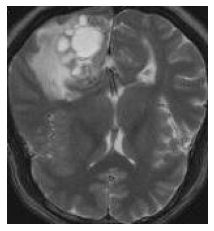

In [29]:
data_dir = 'preprocessed'
# open a random brain image, check if image has been processed
# grayscale -> gaussianBlur -> binary threshold -> erosion -> dilate -> contour
# Crop
img_raw = os.path.join(data_dir, 'malignant', 'y718.jpg')
img = cv2.imread(img_raw)

import matplotlib.pyplot as plt
# Convert image to normal
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)

In [30]:
# for image_class in os.listdir(data_dir):
#     class_dir = os.path.join(data_dir, image_class)
#     for image in os.listdir(class_dir):
#         image_path = os.path.join(class_dir, image)
#         try:
#             tip = imghdr.what(image_path)
#             if tip not in image_extensions:
#                 os.remove(image_path)
#                 print("Removed (invalid format):", image_path)
#             else:
#                 img = cv2.imread(image_path)
#                 if img is None:
#                     os.remove(image_path)
#                     print("Removed (unable to read):", image_path)
#         except Exception as e:
#             print("Error processing:", image_path, "-", str(e))

In [31]:
import numpy as np
from matplotlib import pyplot as plt

In [32]:
# Building the data pipeline
# Reshapes the images to the same size, and normalizes the pixel values to a range of 0 to 1.
data = tf.keras.utils.image_dataset_from_directory('preprocessed')
valid = tf.keras.utils.image_dataset_from_directory('valid')

Found 2904 files belonging to 2 classes.
Found 24 files belonging to 2 classes.


In [33]:
# Accessing the data pipeline
data_iterator = data.as_numpy_iterator()

In [34]:
# Accessing the data itself in the pipeline
batch = data_iterator.next()

In [35]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [36]:
# Class 0 means benign images and Class 1 means malignant
batch[1]

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0], dtype=int32)

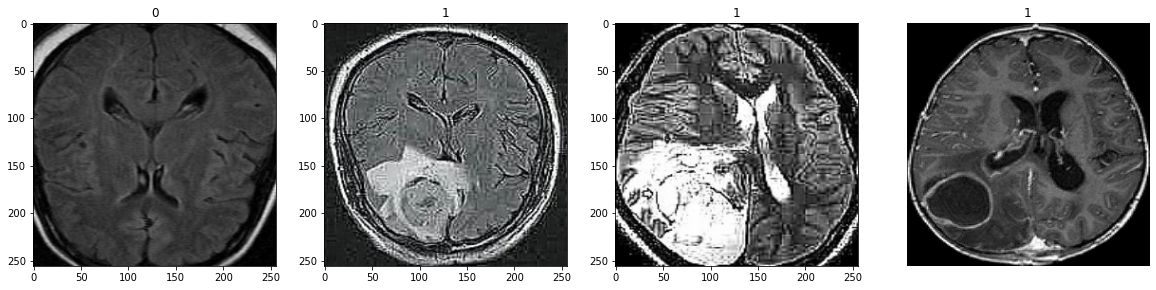

In [37]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
plt.axis('off')
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    plt.axis('off')

In [38]:
data = data.map(lambda x, y: (x/255, y))
valid = tf.keras.utils.image_dataset_from_directory('valid')
valid = valid.map(lambda x, y: (x/255, y))

Found 24 files belonging to 2 classes.


In [39]:
scaled_iterator = data.as_numpy_iterator()

In [40]:
batch = scaled_iterator.next()

In [41]:
batch[0].min()

0.0

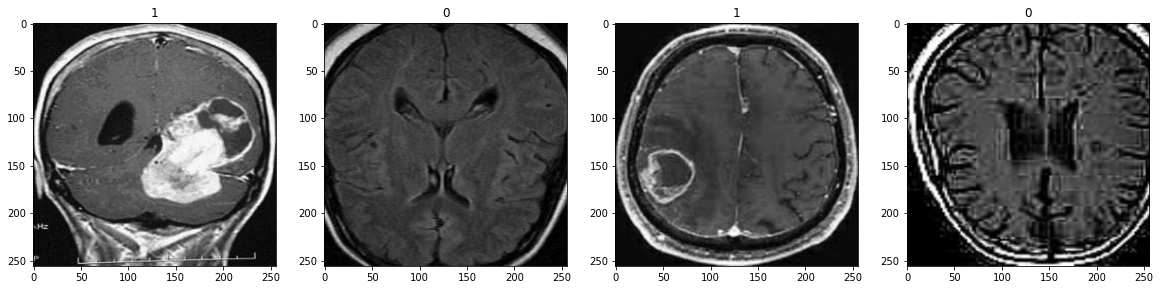

In [42]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [43]:
len(data)

91

In [44]:
train_size = int(len(data))
val_size = int(len(valid))

In [45]:
print(train_size)
print(val_size)

91
1


In [46]:
train = data.take(train_size)
validation = valid.take(val_size)

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow import keras
from tensorflow.keras import layers

In [55]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
])

In [56]:
def make_model(input_shape):
    
    inputs = keras.Input(shape=input_shape)
    
    x = data_augmentation(inputs)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # set aside residual
    previous_block_activation = x
    
    for size in [128, 256, 512, 728]: # 4 dense blocks
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        
        # add back residual
        x = layers.add([x, residual])
        
        # set aside next residual
        previous_block_activation = x

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "sigmoid"
    units = 1
   
    x = layers.Dropout(0.5)(x) # dropout layer
    x = layers.Dense(25, activation='relu')(x)
    outputs = layers.Dense(units, activation=activation)(x)
    
    return keras.Model(inputs, outputs)

In [57]:
image_size = (256, 256)

model = make_model(input_shape=image_size + (3,))

In [58]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [59]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 128, 128, 32  896         ['sequential_1[0][0]']           
                                )                                                                 
                                                                                              

                                                                                                  
 separable_conv2d_5 (SeparableC  (None, 32, 32, 512)  267264     ['activation_7[0][0]']           
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 32, 32, 512)  2048       ['separable_conv2d_5[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 16, 16, 512)  0          ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 16, 16, 512)  131584      ['add_1[0][0]']                  
          

In [60]:
logdir = 'logs'

In [61]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [62]:
epochs = 25

hist = model.fit(train, epochs=epochs, validation_data=validation, callbacks=[tensorboard_callback])

Epoch 1/25


2023-11-01 15:47:50.677623: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8202
2023-11-01 15:47:50.956949: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-01 15:47:51.800567: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-01 15:47:51.994977: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-01 15:47:52.059010: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to al

91/91 [==============================] - 61s 612ms/step - loss: 0.5856 - accuracy: 0.6887 - val_loss: 0.7138 - val_accuracy: 0.3333
Epoch 2/25
91/91 [==============================] - 57s 629ms/step - loss: 0.4776 - accuracy: 0.7831 - val_loss: 0.6381 - val_accuracy: 0.6667
Epoch 3/25
91/91 [==============================] - 60s 660ms/step - loss: 0.3830 - accuracy: 0.8385 - val_loss: 0.7979 - val_accuracy: 0.6667
Epoch 4/25
91/91 [==============================] - 60s 660ms/step - loss: 0.3303 - accuracy: 0.8578 - val_loss: 0.6983 - val_accuracy: 0.6667
Epoch 5/25
91/91 [==============================] - 60s 661ms/step - loss: 0.2857 - accuracy: 0.8802 - val_loss: 0.4015 - val_accuracy: 0.7917
Epoch 6/25
91/91 [==============================] - 61s 672ms/step - loss: 0.2417 - accuracy: 0.9070 - val_loss: 0.1743 - val_accuracy: 0.9167
Epoch 7/25
91/91 [==============================] - 61s 663ms/step - loss: 0.2315 - accuracy: 0.9029 - val_loss: 0.1691 - val_accuracy: 0.9583
Epoch 8/25

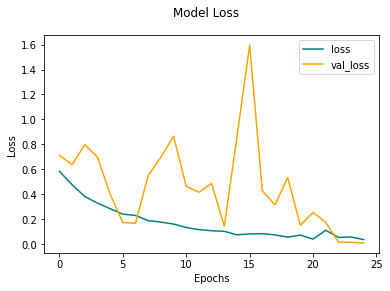

In [63]:
# Plot the model performance
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

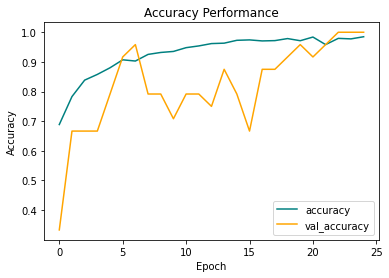

In [64]:
# Plot the accuracy performance
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('Accuracy Performance')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [65]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [66]:
# Only if test set exists as tensors
# true_labels = []
# for image, label in test:
#     # `image` contains the image data
#     # `label` contains the label
#     print(f"Label: {label.numpy()}")
#     true_labels.append(label.numpy())

# true_labels = np.array(true_labels)
# print(true_labels)

In [67]:
test_dir = 'test'

In [68]:
test_images = []
true_labels = []
file_names = []

for label in os.listdir(test_dir):
    for file in os.listdir(os.path.join(test_dir, label)):
            img = cv2.imread(os.path.join(test_dir, label, file))
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            resize = tf.image.resize(img, [256, 256])
            test_images.append(resize)
            true_labels.append(label)
            file_names.append(file)

In [69]:
print(len(test_images), len(true_labels), len(file_names))
print(true_labels)

# Get index of first brain image
index = true_labels.index('malignant')
print(index, file_names[index])

47 47 47
['benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant']
16 49.jpg


In [70]:
true = [1 if label == 'malignant' else 0 for label in true_labels]
true[15]

0

In [71]:
predictions = []
for predict in test_images:
    prediction = model.predict(np.expand_dims(predict/255, 0))
    predictions.append(prediction[0][0])

print(predictions)

1/1 [==============================] - 0s 15ms/step
[0.00015300742, 1.2967017e-07, 1.0526059e-05, 0.055833682, 0.00013391314, 0.04738779, 0.0029890933, 0.0086791925, 1.4558466e-07, 0.00056872005, 0.0004173806, 1.4059552e-05, 0.00030130468, 0.15584317, 0.002945734, 0.00022336503, 0.99989915, 0.98287416, 0.9964546, 0.98259133, 1.0, 0.97699726, 0.9999993, 0.998928, 0.9999994, 0.99947745, 0.99823344, 0.9998276, 0.9999336, 0.99999833, 0.99998987, 8.943671e-05, 0.9994267, 0.9998703, 0.9999958, 0.99999785, 0.9998784, 0.974422, 0.9961063, 0.9999684, 0.9845685, 0.53416836, 0.012840693, 0.99987435, 0.9999987, 0.9999664, 0.99999976]


In [72]:
pred = [1 if prediction >= 0.5 else 0 for prediction in predictions]

In [73]:
# Calculate accuracy
accuracy = accuracy_score(true, pred) #  accuracy
print("Accuracy:", accuracy*100, '%')

# Generate a classification report
class_report = classification_report(true, pred)
print("Classification Report:\n", class_report)

# Create a confusion matrix
confusion = confusion_matrix(true, pred)
print("Confusion Matrix:\n", confusion)

Accuracy: 95.74468085106383 %
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94        16
           1       1.00      0.94      0.97        31

    accuracy                           0.96        47
   macro avg       0.94      0.97      0.95        47
weighted avg       0.96      0.96      0.96        47

Confusion Matrix:
 [[16  0]
 [ 2 29]]


<AxesSubplot:>

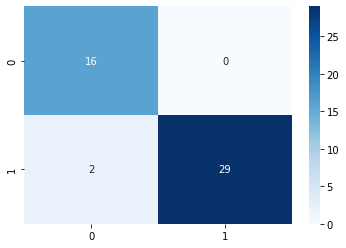

In [74]:
import seaborn as sns
sns.heatmap(confusion, annot=True, cmap='Blues')

In [75]:
model.save('VGG_model.h5')